# EDA

In [36]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import unicodedata


import re
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

In [37]:
data = pd.read_csv("../raw_data/judge-1377884607_tweet_product_company.csv", encoding='unicode_escape')

In [38]:
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

In [39]:
# How do people feel about apple and google products

In [40]:
# How do they compare and which areas can apple improve in, compared to google?
# Product development 
# investment and a company choosing for best electronics to work with
# Brand image
# loyalty

In [41]:
# dopping null column from tweet_text column since it's only one and has no information for our analysis
data.tweet_text.isna().sum()
data.dropna(subset=['tweet_text'], inplace=True)

In [42]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9092
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5388


In [43]:
# looking at our .describe, there seems to be some duplicates in our data and we'll go ahead and keep unique inputs only
data.drop_duplicates(subset=['tweet_text'], inplace=True)

In [44]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9065,3280,9065
unique,9065,9,4
top,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPad,No emotion toward brand or product
freq,1,943,5372


In [45]:
# Creating a cleaned emotion_in tweet_is_directed_at column
data.rename(columns={'emotion_in_tweet_is_directed_at': 'brand'}, inplace=True)
data.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

In [46]:
data['brand'].value_counts()

brand
iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: count, dtype: int64

In [47]:

keywords = ["Apple", "Google", "iPad", "iPhone", "Android"]

for keyword in keywords:
    data[keyword] = data['tweet_text'].str.extract(f'({keyword})', flags=re.IGNORECASE)

In [48]:
data

,tweet_text,brand,sentiment,Apple,Google,iPad,iPhone,Android
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,NaN,NaN,NaN,iPhone,NaN
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,NaN,NaN,iPad,iPhone,NaN
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,NaN,NaN,iPad,NaN,NaN
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,NaN,NaN,NaN,iPhone,NaN
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,NaN,Google,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,NaN,NaN,Ipad,NaN,NaN
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,NaN,google,NaN,NaN,NaN
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,NaN,Google,NaN,NaN,NaN
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,NaN,NaN,NaN,iPhone,NaN


In [49]:
data.describe()

,tweet_text,brand,sentiment,Apple,Google,iPad,iPhone,Android
count,9065,3280,9065,2131,2462,2876,1569,574
unique,9065,9,4,3,3,6,6,3
top,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPad,No emotion toward brand or product,Apple,Google,iPad,iPhone,Android
freq,1,943,5372,1756,2035,2405,1338,439


In [50]:
# Next will combine apple products under apple and google products under
data['product'] = data[['Apple', 'iPhone', 'iPad', 'Google', 'Android']].apply(lambda x: 'Apple' if x[['Apple', 'iPhone', 'iPad']].any() 
                                                                                else 'Google' if x[['Google', 'Android']].any() 
                                                                                else None, axis=1)

In [51]:
data['product'].value_counts()

product
Apple     5517
Google    2764
Name: count, dtype: int64

In [52]:
# Since we've classified our product column, we'll drop nulls as we're interested with apple and google products
data['product'].isna().sum()

784

In [53]:
data.dropna(subset=['product'], inplace=True)

In [54]:
data

,tweet_text,brand,sentiment,Apple,Google,iPad,iPhone,Android,product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,NaN,NaN,NaN,iPhone,NaN,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,NaN,NaN,iPad,iPhone,NaN,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,NaN,NaN,iPad,NaN,NaN,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,NaN,NaN,NaN,iPhone,NaN,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,NaN,Google,NaN,NaN,NaN,Google
...,...,...,...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,NaN,NaN,Ipad,NaN,NaN,Apple
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,NaN,google,NaN,NaN,NaN,Google
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,NaN,Google,NaN,NaN,NaN,Google
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,NaN,NaN,NaN,iPhone,NaN,Apple


In [55]:
data['sentiment'].replace("I can't tell" , "Neutral emotion", inplace=True)

In [56]:
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)

In [57]:
data['sentiment'].replace("No emotion toward brand or product" , "Neutral emotion", inplace=True)

In [58]:
vals_to_replace = {'Positive emotion':2, 'Neutral emotion':1,
                   'Negative emotion':0}

data['sentiment']  = data['sentiment'].replace(vals_to_replace)

In [59]:
data['sentiment'].value_counts()

sentiment
1    4783
2    2930
0     568
Name: count, dtype: int64

In [60]:
def preprocess_tweet(text):
    if isinstance(text, str):
        # Normalize Unicode characters
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        
        # Tokenize the text using regex
        tokens = re.findall(r'\b[A-Za-z]+\b', text.lower())
        
        # Remove stopwords
        stop_words = stopwords.words('english')
        stop_words.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link"])
        tokens = [token for token in tokens if token not in stop_words]
        
        # Lemmatize the tokens
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        # Join the tokens into a string
        preprocessed_text = ' '.join(tokens)
        
        return preprocessed_text
    else:
        return ''

In [61]:
data['processed_text'] = data['tweet_text'].apply(preprocess_tweet)

In [62]:
last = data['processed_text'].iloc[-1]
last

'mention test uicheck offersu'

In [63]:
# nlp_object =  text['preprocessed_tweets'] # Your NLP object (e.g., tokenized sentence or document)
# preprocessed_text = preprocess_tweet(nlp_object)

In [64]:
X = data.tweet_text
y = data.sentiment

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [66]:
sw = stopwords.words('english')
sw.extend(["apple", "google", "ipad", "iphone", "android", "sxsw", "link", "mention", "sxwsi", "rt"])

In [67]:
# The below codes have been adopted from Flatiron school on NLP preprocessing and modeling

In [68]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [69]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [70]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [71]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train,
                                          test_size=0.25, random_state=42)

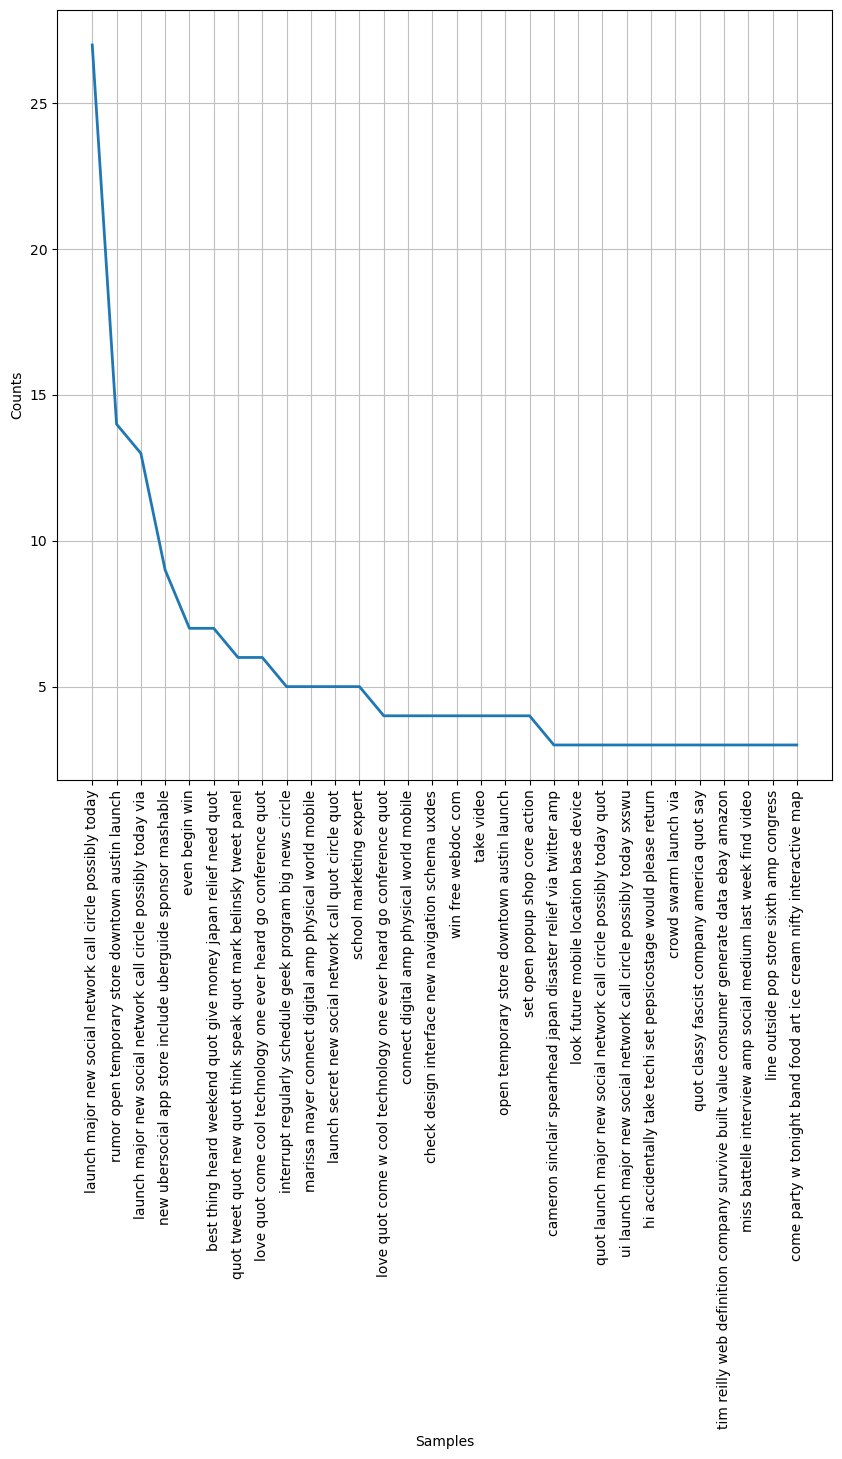

In [72]:
fdist = FreqDist(X_t)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [73]:
# Accuracy increased with all features

In [74]:
cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [75]:
X_t_vec

,aa,aaaa,aapl,aaron,aarpbulletin,ab,abba,abc,ability,able,...,zing,zip,zms,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
7171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6779,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


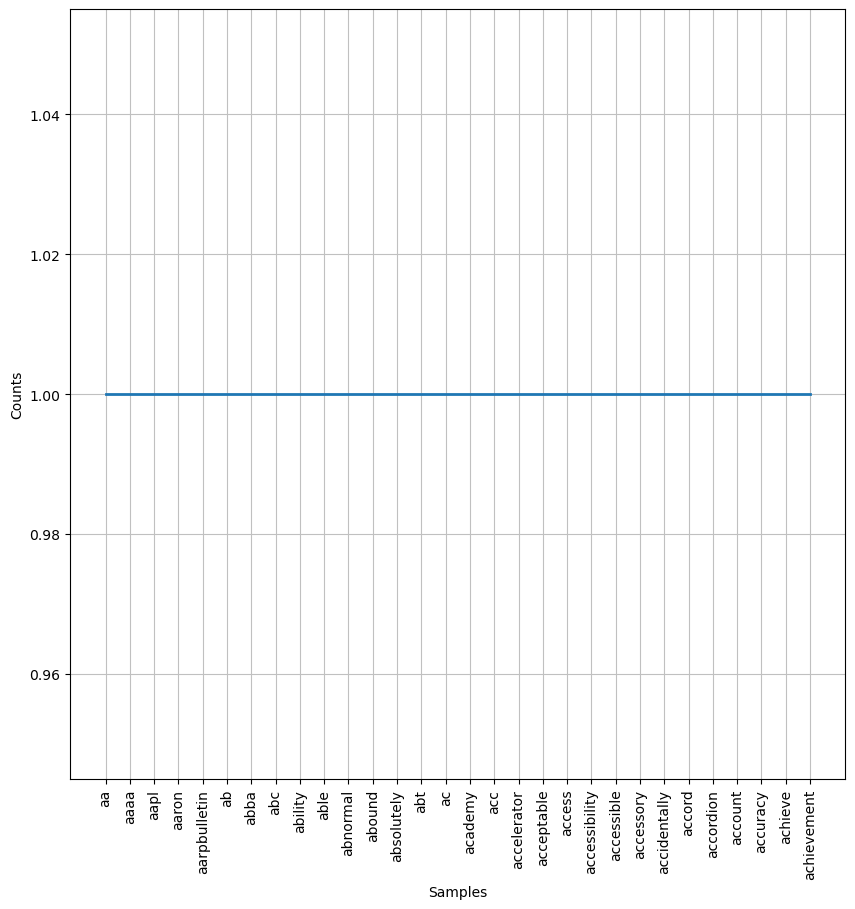

In [76]:
fdist = FreqDist(X_t_vec)
plt.figure(figsize=(10, 10))
fdist.plot(30);

In [77]:
X_val_vec = cv.transform(X_val)

In [78]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [79]:
y_hat = mnb.predict(X_val_vec)
accuracy_score(y_val, y_hat)

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


0.6580811332904056

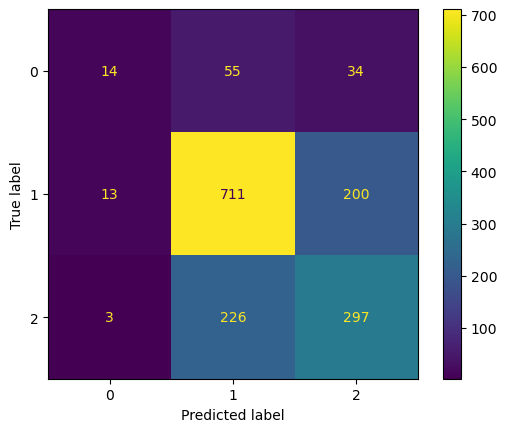

In [80]:

cm = confusion_matrix(y_val, y_hat)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [81]:
len(cv.vocabulary_)

5701

In [82]:
cv = CountVectorizer(min_df=0.05, max_df=0.95)

X_t_vec = cv.fit_transform(X_t)

X_val_vec = cv.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat, average='weighted')

0.5360205188755309

In [83]:
# fdist = FreqDist(X_t_vec)
# plt.figure(figsize=(10, 10))
# fdist.plot(30);

TypeError: unhashable type: 'csr_matrix'

In [ ]:
# Now let's see what happens with TF-IDF

In [93]:
tfidf = TfidfVectorizer()

X_t_vec = tfidf.fit_transform(X_t)

X_val_vec = tfidf.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat, average='weighted')

0.683761579296138

In [94]:
tfidf = TfidfVectorizer(min_df=0.05, max_df=0.95)

X_t_vec = tfidf.fit_transform(X_t)

X_val_vec = tfidf.transform(X_val)

mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)

precision_score(y_val, y_hat, average='weighted')

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5200775740376837

In [95]:
rf = RandomForestClassifier(n_estimators=1000, max_features=5, max_depth=5)
rf.fit(X_t_vec, y_t)
y_hat = rf.predict(X_val_vec)
precision_score(y_val, y_hat, average='weighted')

/Users/danayt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5486991011546719

In [96]:
importances = rf.feature_importances_

In [97]:
sorted_indices = importance.argsort()[::-1]
sorted_indices

array([ 1,  3,  0,  4,  2, 15, 13, 12,  8,  9,  6, 14, 16,  5, 11, 10,  7])

In [91]:
for i in sorted_indices:
    print(f"Feature: {feature_names_out[i]}, Importance: {importances[i]}")

NameError: name 'feature_names_out' is not defined